# Tutorial 3: mouse somatosensory cortex by osmFISH

the osmFISH data is available at http://linnarssonlab.org/osmFISH/availability/

## Loading and Preparing Data

In [1]:
import pandas as pd  
import numpy as np  
import scanpy as sc  
import matplotlib.pyplot as plt  
from sklearn.metrics import adjusted_rand_score  
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi  
from SEPAR_model import SEPAR 

# Read data  
# adata = sc.read_h5ad(filename='osmfish_remove_excluded.h5ad')  
filename = '/Users/zhang/Desktop/st_square/draft/osmfish/osmfish_remove_excluded.h5ad'
adata = sc.read_h5ad(filename)
adata.var_names_make_unique()  

# Get spatial coordinates  
loc = adata.obsm['spatial']  

# Get ground truth annotations  
Y_list = adata.obs['Region']  
n_cluster = len(Y_list.unique())  

# Initialize SEPAR  
separ = SEPAR(adata, n_cluster=n_cluster)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data Preprocessing

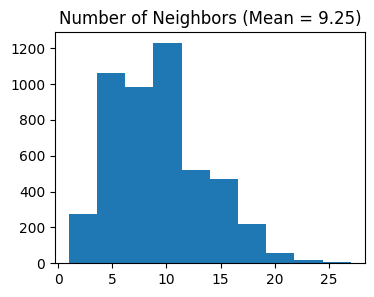

In [2]:
# Compute spatial graph with custom radius  
separ.compute_graph(radius_rate=1.1)  

# Compute weights  
separ.compute_weight(n_cluster=n_cluster)

## 1. Running SEPAR Algorithm

In [3]:
# Run SEPAR algorithm  
separ.separ_algorithm(  
    r=30,              # Number of spatial patterns  
    alpha=1.0,         # Graph regularization weight  
    beta=0.05,         # Sparsity penalty weight (previously l1)  
    gamma=0.01         # Pattern orthogonality weight (previously lam)  
)

Processing iterations: 100%|██████████| 100/100 [00:00<00:00, 128.77it/s]


### Pattern Visualization

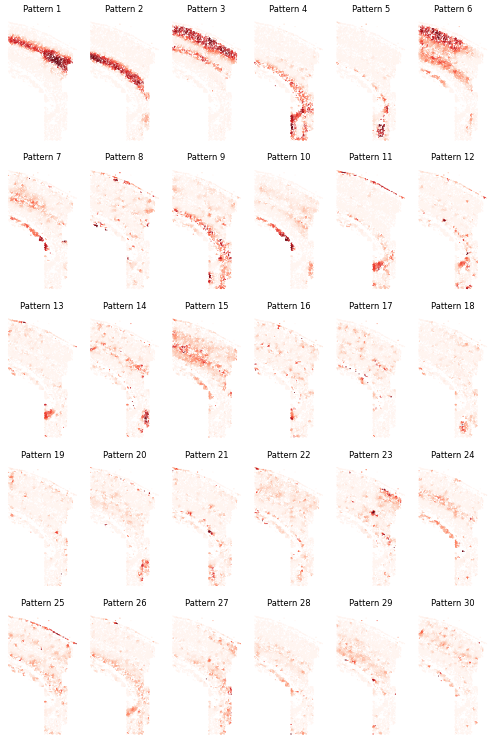

In [4]:
# Calculate pattern significance  
sim_slt = separ.sim_res(separ.Wpn, separ.Hpn, separ.Xt.T)  
sim_argsort = np.argsort(-sim_slt)  

# Visualize patterns  
num_patterns = 30  
plt.figure(dpi=50, figsize=(10, 15))  
for i in range(num_patterns):  
    ii = sim_argsort[i]  
    plt.subplot(5, int(np.ceil(num_patterns/5)), i + 1)  
    plt.scatter(separ.loc[:, 0], separ.loc[:, 1],   
                c=separ.Wpn[:, ii].reshape(-1, 1),   
                s=0.2, cmap='Reds')  
    plt.axis('off')  
    plt.title(f'Pattern {i + 1}',   
              fontsize=12)  

plt.tight_layout()  
plt.show()

## 2. Performing Clustering and Evaluation

In [5]:
# Perform clustering  
cluster_res = separ.clustering(  
    n_cluster=n_cluster,  
    N1=0,  
    N2=0  
)  

# Calculate clustering metrics  
Ari = adjusted_rand_score(Y_list, separ.labelres)  
Nmi = nmi(Y_list, separ.labelres)

### Clustering Results Visualization

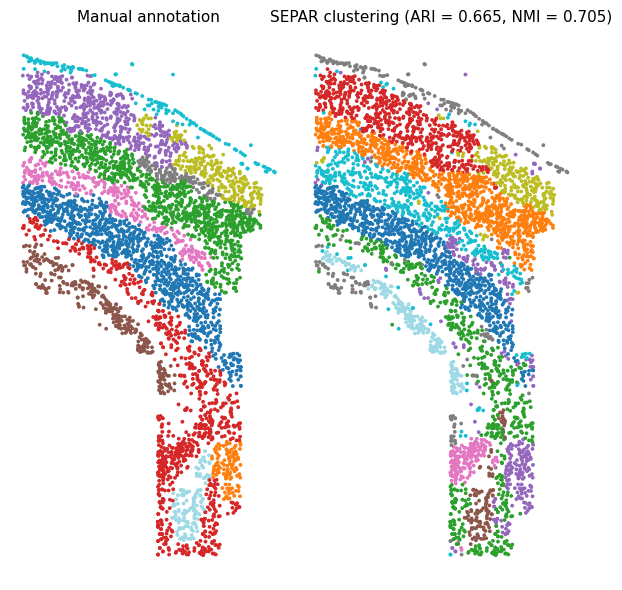

In [6]:
# Create comparison visualization  
fig, axs = plt.subplots(1, 2, figsize=(6, 6))  

# Ground truth annotation  
scatter = axs[0].scatter(separ.loc[:, 0], separ.loc[:, 1],   
                        c=Y_list.map(lambda x: list(Y_list.unique()).index(x)),   
                        s=3, cmap='tab20')  
axs[0].set_title("Manual annotation", fontsize=11)  
axs[0].axis('off')  

# SEPAR clustering results  
scatter = axs[1].scatter(separ.loc[:, 0], separ.loc[:, 1],   
                        c=separ.labelres, s=3, cmap='tab20')  
axs[1].set_title(f"SEPAR clustering (ARI = {Ari:.3f}, NMI = {Nmi:.3f})",   
                 fontsize=11)  
axs[1].axis('off')  

plt.tight_layout()  
plt.show()

## 3. Gene Expression Refinement

In [7]:
adata_refined = separ.get_refined_expression()

### Evaluating Refinement Performance  

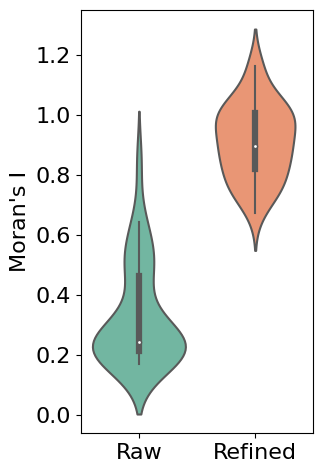

In [8]:
# Calculate Moran's I for both raw and refined data  
morani = sc.metrics.morans_i(separ.adata)  
morani_refine = sc.metrics.morans_i(adata_refined)  

# Create DataFrame for violin plot  
data_violin = pd.DataFrame({  
    'Moran\'s I': np.concatenate([morani, morani_refine]),  
    'Condition': ['Raw'] * len(morani) + ['Refined'] * len(morani_refine)  
})  

import seaborn as sns
# Create violin plot  
plt.rcParams['font.size'] = 16  
plt.figure(figsize=(3, 5.5))  
sns.violinplot(x='Condition', y='Moran\'s I', data=data_violin, palette='Set2')  
plt.ylabel('Moran\'s I')  
plt.xlabel('')  
plt.show()  

### Single Gene Visualization

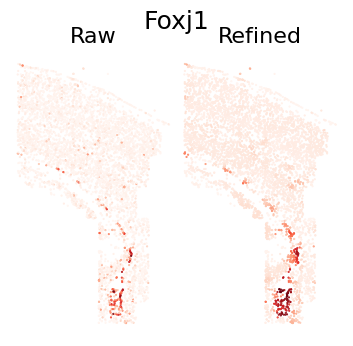

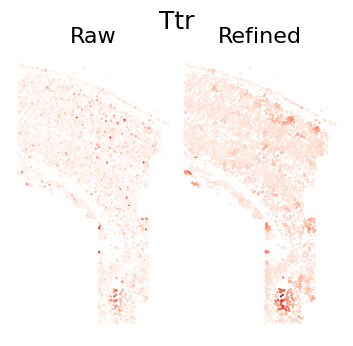

In [9]:
def plot_gene_refinement(gene_name, separ, adata_refined):  
    """  
    Visualize raw and refined expression patterns for a specific gene.  
    
    Parameters  
    ----------  
    gene_name : str  
        Name of the gene to visualize  
    separ : SEPAR object  
        SEPAR object containing raw data  
    adata_refined : AnnData  
        Refined expression data from get_refined_expression()  
    """  
    # Get gene index and expression values  
    gene_idx = separ.adata.var_names.get_loc(gene_name)  
    raw_exp = separ.adata[:, gene_idx].X.toarray().flatten()  
    refined_exp = adata_refined.X[:, gene_idx]  

    # Create comparison plot  
    plt.rcParams['font.size'] = 16  
    plt.figure(dpi=100, figsize=(4/1.2, 4/1.2))  
    
    # Set main title  
    plt.suptitle(gene_name, fontsize=18)  
    
    # Plot raw expression  
    plt.subplot(1, 2, 1)  
    plt.scatter(separ.loc[:, 0], separ.loc[:, 1],  
                c=raw_exp, s=0.3, cmap='Reds', rasterized=True)  
    plt.axis('off')  
    plt.title('Raw', fontsize=16)  
    
    # Plot refined expression  
    plt.subplot(1, 2, 2)  
    plt.scatter(separ.loc[:, 0], separ.loc[:, 1],  
                c=refined_exp, s=0.3, cmap='Reds', rasterized=True)  
    plt.axis('off')  
    plt.title('Refined', fontsize=16)  
    
    plt.tight_layout(pad=0)  
    plt.show()  

plot_gene_refinement("Foxj1", separ, adata_refined)
plot_gene_refinement("Ttr", separ, adata_refined)